Time-Varying Vertical Swimming in Coupled DFM/DWAQ
==

Online coupled runs have been important for the Lagrangian simulations, but so far 
the vertical swimming component has been specified in the DFM configuration on
a tracer-by-tracer basis.

Test whether vertical velocities configured in DWAQ can enable time-varying (or
more complex variability) swimming speeds.

Result: constant and time-varying swim speed can be configured via DWAQ. Appears that
spatially varying swim speed is not handled.

Didn't test whether dynamically computed swim speed could be incorporated, but I'm
guessing that's not supported.

In [1]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [4]:
import os, glob, shutil
import datetime
import six
import xarray as xr
import pandas as pd
import re

from stompy.spatial import field, proj_utils
from stompy import utils
from stompy.plot import plot_wkb, plot_utils
import xarray as xr
import stompy.plot.cmap as scmap
from scipy import ndimage

import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
import stompy.model.delft.io as dio

from stompy.model import unstructured_diffuser
from stompy.grid import unstructured_grid
from stompy.io.local import noaa_coops
from shapely import geometry
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

In [5]:
import bloom_common
import insitu_temperature

DFM-based Runs
==

In [6]:
grid = unstructured_grid.UnstructuredGrid()

Lx=1000
Ly=50
dx=50

grid.add_rectilinear([0,0],[Lx,Ly], 1+Lx//dx, 1+Ly//dx)
shore_poly = grid.boundary_polygon()

INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=50000.000000, 0 potential interiors


(-50.0, 1050.0, -2.5, 52.5)

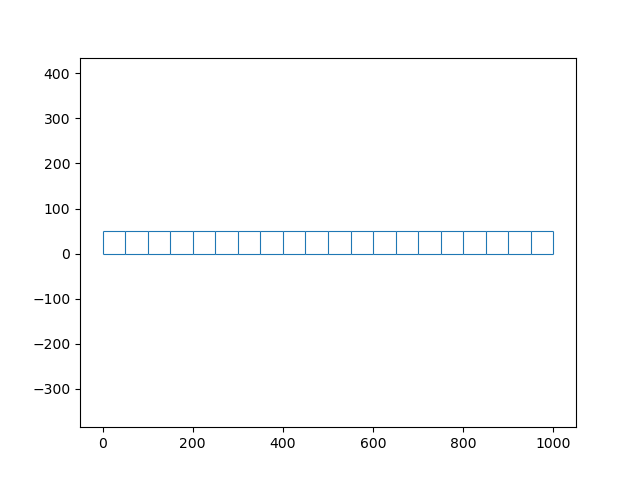

In [7]:
fig,ax=plt.subplots()
grid.plot_edges()

grid.add_node_field('z_bed',np.full(grid.Nnodes(),-10))
ax.axis('equal')

In [26]:
# First, get a basic restart going
import stompy.model.delft.waq_scenario as waq
from stompy.model.delft import custom_process
import stompy.model.delft.dflow_model as dfm
six.moves.reload_module(waq)
six.moves.reload_module(custom_process)


class SwimTest(custom_process.CustomProcesses, dfm.DFlowModel):
    dwaq=True
    run_dir="swim_test00"
    run_start = np.datetime64("2000-01-01")
    run_stop = np.datetime64("2000-01-02")
    num_procs = 1
    
    tracer_configs=[ dict(fall_velocity_m_s= -5.0/86400, release='uniform'),
                     dict(fall_velocity_m_s=-10.0/86400, release='uniform'),
                     dict(fall_velocity_m_s=0, release='uniform')
                   ]
    
    def configure_general(self):
        bloom_common.configure_dfm_t141798()

        self.mdu['geometry','Kmx'] = 10
        self.mdu['output','WaqInterval']="" # no need for DWAQ output
        self.dfm_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')
        self.mpi_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')

        # 2024-05-23: Getting "flownode mismatches", and this was 1. So trying 0...
        self.mdu['geometry','RenumberFlowNodes']=0
        
        self.mdu['output','MapInterval' ] = 600

        # run_dfm_rs_chl for other entries that may have to be dropped.
        #del self.mdu['waves','WaveNikuradse']

        self.mdu['physics','Temperature'] = 0 # and fix-up tracers below
        self.mdu['physics','Salinity'] = 0 # and fix-up tracers below

        # for non-restart this is handled by configure(), but restart doesn't call that.
        #if self.dwaq is True:                                                                                              
        #    self.dwaq=dwaq.WaqOnlineModel(model=self)
            
    def set_bloom_tracers(self):
        self.dwaq.substances['passive']=dwaq.Substance(initial=1.0)
        self.dwaq.substances['swimdfm']=dwaq.Substance(initial=1.0)
        
        self.dwaq.substances['bloomalg01']=dwaq.Substance(initial=1.0)
        self.dwaq.parameters['VSedAlg01']= 0.0             
        self.dwaq.add_process('SEDAlg01')        

        self.dwaq.substances['bloomalg02']=dwaq.Substance(initial=1.0)
        self.dwaq.parameters['VSedAlg02']= -10.0 # pretty sure DWAQ expects this in m/d, positive down            
        self.dwaq.add_process('SEDAlg02')

        self.dwaq.substances['bloomalg03']=dwaq.Substance(initial=1.0)
        # self.dwaq.parameters['VSedAlg03']=dwaq.ParameterSpatial-10.0 # manually written in modify_forcing            
        self.dwaq.add_process('SEDAlg03')

        self.dwaq.substances['bloomalg04']=dwaq.Substance(initial=1.0)        
        times = np.array( [ self.run_start,
                            self.run_start + np.timedelta64(10,'h'),
                            self.run_start + np.timedelta64(11,'h'),
                            self.run_stop], 'M8[ns]')
        self.dwaq.parameters['VSedAlg04']=dwaq.ParameterTemporal( times = times,
                                                                  values=[-10,-10,10,10])
        self.dwaq.add_process('SEDAlg04')        
        
        # global
        self.dwaq.parameters['TaucS']=0.0 # no deposition - covers all algae.
        self.dwaq.parameters['Tau']=0.1 # should be possible to have DFM supply this..

        # And the custom settling
        self.dwaq.substances['fall1']=dwaq.Substance(initial=1.0)
        self.dwaq.parameters['vfall1']=-10.0
        self.custom_fall_velocity(sub='fall1',fall_rate='vfall1')

        self.dwaq.substances['fall2']=dwaq.Substance(initial=1.0)
        self.dwaq.parameters['vfall2']=dwaq.ParameterTemporal( times = times,
                                                               values=[-10,-10,10,10])
        self.custom_fall_velocity(sub='fall2',fall_rate='vfall2')
    
    def modify_forcing(self):
        return # see if tracer config can be copied through
        
        # take a more low-level approach compared to usual BC configuration
        # so that we can be very careful about what things change.
        ext_fn=self.mdu.filepath(('external forcing','ExtForceFile'))

        x0,x1,y0,y1 = model.grid.bounds()
        bounds=[ ('bounds', np.array([ [x0,y0],[x1,y0],[x1,y1],[x0,y1] ])) ]

        # WaqOnlineModel needs to be setting ICs like this:
        
        with open(ext_fn,'wt') as fp_new:
            for tracer in self.dwaq.substances:        
                pli_fn=f"{tracer}-ic.pli"
                with open(os.path.join(self.run_dir,pli_fn),'wt') as fp_pli:
                    dio.write_pli(fp_pli,bounds)
                fp_new.write("\n# NEW TRACERS\n"
                             f"QUANTITY=initialtracer{tracer}\n"
                             f"FILENAME={pli_fn}\n"
                             "FILETYPE=10\n"
                             "METHOD=4\n"
                             "OPERAND=O\n"
                             "VALUE=10.0\n")

                if tracer=='swimdfm':
                    w=-10.0 / 86400
                    fp_new.write(f"TRACERFALLVELOCITY={w:.8f}\n")
                fp_new.write("\n")


            if 0: # didn't work.
                xyz_fn=f"VSedAlg03.xyz"
                xyz=np.concatenate( (self.grid.nodes['x'],10.0+np.zeros( (self.grid.Nnodes(),1))), axis=1)
                xyz[ xyz[:,0] < Lx/3  , 2] = -10.0
                xyz[ xyz[:,0] > 2*Lx/3, 2] = 10.0
                np.savetxt(os.path.join(self.run_dir,xyz_fn), xyz, fmt="%.6g")
                
                fp_new.write("\n# Spatially varying swimming\n"
                             f"QUANTITY=waqparameterVSedAlg03\n"
                             f"FILENAME={xyz_fn}\n"
                             "FILETYPE=7\n"
                             "METHOD=5\n"
                             "OPERAND=O\n")
            if 1: # didn't work.
                pli_fn=f"VSedAlg03.pli"
                with open(os.path.join(self.run_dir,pli_fn),'wt') as fp_pli:
                    dio.write_pli(fp_pli,bounds)
                fp_new.write("QUANTITY=waqparameterVSedAlg03\n"
                             f"FILENAME={pli_fn}\n"
                             "FILETYPE=10\n"
                             "METHOD=4\n"
                             "OPERAND=O\n"
                             "VALUE=-10.0\n")

            tim_fn=f"VSedAlg04.tim"
            fp_new.write("\n# Time-varying swimming\n"
                         f"QUANTITY=waqfunctionVSedAlg04\n"
                         f"FILENAME={tim_fn}\n"
                         "FILETYPE=1\n"
                         "METHOD=1\n"
                         "OPERAND=O\n")

    def setup_and_run(self):
        self.configure_general()
        self.set_bloom_tracers()
        self.write()
        
        # This updates the BC data in place. Do it here so that 
        # we have a starting ext file which will be updated with
        # new tracers.
        self.modify_forcing()
        
        self.partition()
        self.run_simulation()
            


In [27]:
model = SwimTest(grid=grid)
model.setup_and_run()


INFO:HydroModel:Could not find BC to get initial water level
INFO:WaqOnlineModel:Updating mdu with Delwaq settings...
INFO:WaqOnlineModel:Writing Delwaq model files...
INFO:WaqOnlineModel:Ignoring only_active for online WAQ configuration
INFO:DFlowModel:Writing MDU to swim_test00/flowfm.mdu
INFO:HydroModel:Copying source process tables


Would be writing temporal parameter to external forcing file
Would be writing temporal parameter to external forcing file
First call to waqpb_export
Suppressed output
First call to waqpb_export DONE
Calling waqpb_import


Normal end


Suppressed output
Return from waqpb_import
Second call to waqpb_export


Normal end


Suppressed output
Return from second call to waqpb_export


Normal end
INFO:HydroModel:Running command: /opt/anaconda3/envs/dfm_t141798/bin/dflowfm -t 1 --autostartstop flowfm.mdu --processlibrary /richmondvol1/rusty/wy2022_bloom/swim_test00/proc_tables/proc_def.def


Top of partition: num_procs=1


In [32]:
map_ds = model.map_dataset()
map_ds.close()
map_ds = model.map_dataset()

grid_out = unstructured_grid.UnstructuredGrid.read_ugrid(map_ds)

In [33]:
map_ds

<xarray.Dataset>
Dimensions:                      (nmesh2d_EnclosurePoints: 43,
                                  nmesh2d_EnclosureInstance: 1,
                                  nmesh2d_EnclosureParts: 1, nNetNode: 42,
                                  nNetLink: 61, nNetLinkPts: 2, nNetElem: 20,
                                  nNetElemMaxNode: 4, nNetLinkContourPts: 4,
                                  nBndLink: 42, nFlowElem: 20,
                                  nFlowElemContourPts: 4, nFlowLink: 19,
                                  nFlowLinkPts: 2, time: 145, laydim: 10,
                                  wdim: 11)
Coordinates:
    NetNode_x                    (nNetNode) float64 0.0 0.0 50.0 ... 1e+03 1e+03
    NetNode_y                    (nNetNode) float64 0.0 50.0 0.0 ... 0.0 50.0
    FlowElem_xcc                 (nFlowElem) float64 ...
    FlowElem_ycc                 (nFlowElem) float64 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2000-01-01 ... 2000-01-02
    LayCoord_cc                  (laydim) float64 ...
    LayCoord_w                   (wdim) float64 ...
Dimensions without coordinates: nmesh2d_EnclosurePoints,
                                nmesh2d_EnclosureInstance,
                                nmesh2d_EnclosureParts, nNetNode, nNetLink,
                                nNetLinkPts, nNetElem, nNetElemMaxNode,
                                nNetLinkContourPts, nBndLink, nFlowElem,
                                nFlowElemContourPts, nFlowLink, nFlowLinkPts,
                                laydim, wdim
Data variables: (12/61)
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 ...
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enclosure_container   float32 ...
    ...                           ...
    swimdfm                      (time, nFlowElem, laydim) float64 ...
    turkin1                      (time, nFlowLink, wdim) float64 ...
    vicwwu                       (time, nFlowLink, wdim) float64 ...
    tureps1                      (time, nFlowLink, wdim) float64 ...
    czs                          (time, nFlowElem) float64 ...
    czu                          (time, nFlowLink) float64 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.167.141798M, Jun 09 2023,...
    history:        Created on 2024-08-08T07:34:33-0700, D-Flow FM
    date_created:   2024-08-08T07:34:33-0700
    date_modified:  2024-08-08T07:34:33-0700
    Conventions:    UGRID-0.9
    uuid:           9c67ed50-b942-4538-814e-2f198835d153
    grid:           <stompy.grid.unstructured_grid.UnstructuredGrid object at...

Text(0.5, 1.0, 'Bed')

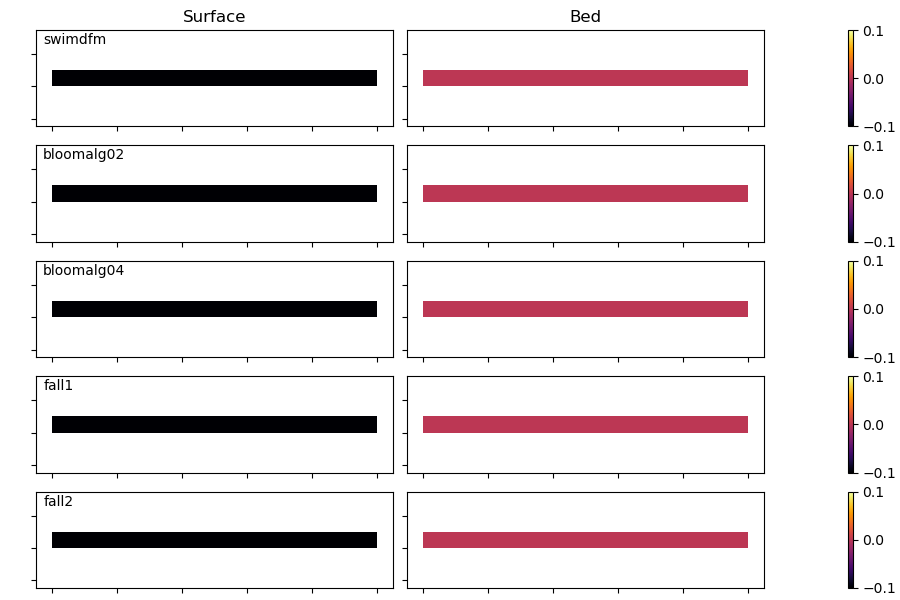

In [34]:
# Keep all tracer names fully lower case, for round-tripping.
# Appears that constant parameter value for swimming works.
# Spatial: alg03. Naming seems correct. Check manual for other details. Not working atm
# Time series: works.

# Need layers, and fix constant IC
tracers=[#'passive',
         'swimdfm',
         #'bloomalg01',
         'bloomalg02',
         #'bloomalg03',
         'bloomalg04','fall1','fall2']

fig,axs=plt.subplots(len(tracers),2,figsize=(9,6))
fig.subplots_adjust(left=0.04,right=0.97,top=0.95,bottom=0.02,wspace=0.04)

tidx=-1
#tidx=70 

cmap='inferno'
for ax_surf,ax_bed,tracer in zip(axs[:,0],axs[:,1],tracers):
    clim=[0,map_ds[tracer].isel(time=tidx).max()]
    coll_surf = grid_out.plot_cells(values=map_ds[tracer].isel(time=tidx,laydim=-1).values,cmap=cmap,ax=ax_surf,clim=clim)
    ax_surf.axis('equal')
    coll_bed = grid_out.plot_cells(values=map_ds[tracer].isel(time=tidx,laydim=0).values,cmap=cmap,ax=ax_bed,clim=clim)
    ax_bed.axis('equal')
    plt.colorbar(coll_bed,ax=[ax_surf,ax_bed],fraction=0.03,pad=0.1)
    ax_surf.text(0.02,0.97,tracer,transform=ax_surf.transAxes,va='top')

for ax in axs.ravel():
    plt.setp(ax.get_xticklabels(),visible=0)
    plt.setp(ax.get_yticklabels(),visible=0)

axs[0,0].set_title('Surface')
axs[0,1].set_title('Bed')